<h2>Format the Data Into Dictionary<h2>

<div class="alert alert-block alert-info">
</b>First, make a dictionary where the key is competitor and the value is their wikipedia text</div>

In [1]:
# Read File
with open(r"C:\Users\ulian\OneDrive\Pictures\Documents\competitors_data.txt", "r", encoding="utf-8") as file:
    content = file.read()

# Seperate competitors
separate_competitors = content.split("---")

# Remove following and leading spaces
for i in range(len(separate_competitors)):
    separate_competitors[i] = separate_competitors[i].strip()

# Make a dictionary out of competitors and their descriptions
competitor_dict = {}

for text in separate_competitors:
    lines = text.split("\n")  
    first_line = lines[0]  
    
    if first_line.startswith("Competitor: "):  
        competitor_name = first_line.replace("Competitor: ", "").strip()  
        competitor_dict[competitor_name] = "\n".join(lines[1:]) 

# Remove competitors with no text
import re

def clean_dict(d):
    return {k: v for k, v in d.items() if v and re.search(r'\w', str(v))}
competitor_dict = clean_dict(competitor_dict)

In [2]:
print(competitor_dict.keys())

dict_keys(['Orient', 'Citizen', 'Hamilton', 'Certina', 'Glycine', 'Steinhart', 'Tissot', 'Luminox', 'Garmin', 'Suunto', 'REACTOR', 'Bulova', 'Casio', 'Apple Watch', 'Rolex', 'Omega', 'TAG Heuer', 'Timex', 'G-SHOCK', 'Grand Seiko'])


<h2>Clean & Preprocess Data <h2>

In [3]:
import re
import spacy
from nltk.corpus import stopwords

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Lowercase text
    text = text.lower()

    # Remove special characters/punctuation
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    doc = nlp(text)
    filtered_tokens = [token.text for token in doc if token.text not in stop_words]

    # Lemmatize 
    lemmatized_text = ' '.join(filtered_tokens)
    return lemmatized_text



In [4]:
# Dictionary to store cleaned texts
cleaned_texts = {}

# Clean text of each competitor
for brand, text in competitor_dict.items():
    cleaned_texts[brand] = preprocess_text(text)

for brand, text in cleaned_texts.items():
    print(f"{brand}: {text[:200]}...")  


Orient: orient   oriento tokei kabushikigaisha japanese watch manufacturer founded   established independent company   became functional subsidiary epson   fully integrated company 
 absorbed epson orient wat...
Citizen: citizen watch co ltd   shichizun tokei kabushikigaisha also known citizen group electronics company primarily known watches core company japanese global corporate group based nishitokyo tokyo japan ad...
Hamilton: hamilton watch company swiss manufacturer wristwatches based bienne switzerland founded   american firm hamilton watch company ended american manufacture   shifting manufacturing operations buren fact...
Certina: certina sa swiss watch brand part swatch group founded grenchen   adolf alfred kurth certina watches bear swiss made seal origin 
 certina watches related german industrial conglomerate certina holdin...
Glycine: glycine watch sa simply glycine    swiss watchmaker founded   bielbienne switzerland manufacturing headquarters remain today   glycine rele

<div class="alert alert-block alert-info">
</b>Remove names of companies and some irrelevent terms from text</div>

In [6]:
brand_names = ['orient', 'citizen', 'hamilton', 'certina', 'glycine', 'steinhart', 
               'tissot', 'luminox', 'garmin', 'suunto', 'reactor', 'bulova', 
               'casio', 'apple', 'rolex', 'omega', 'tag heuer', 'timex', 
               'g-shock', 'grand seiko', 'seiko', 'watch', 'watches', 'innovation', 'introduces', 'new', 'model', 'launch', 'recently', 'introduce', 
               'apple', 'orient', 'citizen', 'hamilton', 'certina', 'glycine', 'steinhart', 'tissot', 
               'luminox', 'garmin', 'suunto', 'reactor', 'bulova', 'casio', 'apple watch', 'rolex', 
               'omega', 'tag heuer', 'timex', 'g-shock', 'grand seiko', 'watch', 'selling', 'shop', 
               'wrist', 'timepiece', 'time', 'brand', 'model', 'watchmaker', 'company', 'design', 
               'camera', 'part', 'piece', 'watch', 'part', 'system', 'day', 'month', 'minute', 
               'second', 'time', 'designer', 'seiko', 'brand', 'systems', 'include', 'acquired', 'products',
               'technology', 'world', 'brand', 'new', 'official', 'time', 'movement', 'introduced', 'available', 
               'case', 'new', 'gshock', 'models', 'series', 'design', 'movements'
]

# Pattern to handle different variations of names 
brand_pattern = r'\b(' + '|'.join(map(re.escape, brand_names)) + r')(s|\'s|es)?\b'

def remove_brand_names(text):
    cleaned_text_no_brand = re.sub(brand_pattern, '', text, flags=re.IGNORECASE)  # Remove brand name and variations (e.g., "casio's")
    cleaned_text_no_brand = re.sub(r'\s{2,}', ' ', cleaned_text_no_brand)  # Remove extra spaces
    return cleaned_text_no_brand.strip()

cleaned_texts_no_brand = {brand: remove_brand_names(text) for brand, text in cleaned_texts.items()}

for brand, text in cleaned_texts_no_brand.items():
    print(f'{brand}: {text[:150]}...')  # Print first 150 characters to verify

Orient: oriento tokei kabushikigaisha japanese manufacturer founded established independent became functional subsidiary epson fully integrated absorbed epson...
Citizen: co ltd shichizun tokei kabushikigaisha also known group electronics primarily known core japanese global corporate group based nishitokyo tokyo japan ...
Hamilton: swiss manufacturer wristwatches based bienne switzerland founded american firm ended american manufacture shifting manufacturing operations buren fact...
Certina: sa swiss swatch group founded grenchen adolf alfred kurth bear swiss made seal origin related german industrial conglomerate holding history sa sa fou...
Glycine: sa simply swiss founded bielbienne switzerland manufacturing headquarters remain today released first massproduced automatic developed vacuumsealed al...
Steinhart: valjoux valle de joux joux valley swiss manufacturer mechanical known primarily chronograph bauche used number mid highrange mechanical eta member swa...
Tissot: sa french pr

## TF-IDF Vectorization/Bag of Words (BoW) Vectorization

<div class="alert alert-block alert-info">
</b>The TfidfVectorizer transforms text into numerical vectors based on the term frequency-inverse document 
frequency (TF-IDF) method, highlighting important words while reducing the weight of common words. 
The CountVectorizer, on the other hand, represents text as a matrix of word counts, capturing the frequency 
of each word's occurrence. We use these techniques to convert text data into numerical features that
machine learning algorithms can process</div>

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=3, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_texts_no_brand.values())

# BoW for LDA
bow_vectorizer = CountVectorizer(max_df=0.75, min_df=3, stop_words='english')
bow_matrix = bow_vectorizer.fit_transform(cleaned_texts_no_brand.values())


<h2> Latent Dirichlet Allocation (LDA)<h2>

<div class="alert alert-block alert-info">
We use Latent Dirichlet Allocation (LDA) here to uncover hidden topics within the text data. 
LDA is a generative model that assumes each document is a mixture of topics, 
and each topic is a distribution over words. 

By applying LDA to the word frequency matrix (created with either CountVectorizer or TfidfVectorizer), 
we can identify the key themes (topics) that dominate the documents, allowing us to analyze 
and group similar content, which is useful for understanding patterns, trends, 
and relationships in large text datasets.</div>

In [9]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 5 
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_matrix = lda.fit_transform(bow_matrix) 

n_words = 10
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx + 1}:")
    print([feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]])
    print()


Topic 1:
['compass', 'accutron', 'core', 'sports', 'functions', 'production', 'training', 'sold', 'edition', 'heart']

Topic 2:
['japan', 'released', 'quartz', 'line', 'display', 'launched', 'solar', 'corporation', 'japanese', 'module']

Topic 3:
['color', 'gps', 'features', 'apps', 'app', 'product', 'options', 'september', 'united', 'gold']

Topic 4:
['sa', 'ds', 'geneva', 'mm', 'sold', 'perpetual', 'date', 'wristwatch', 'observatory', 'chronograph']

Topic 5:
['quartz', 'mechanical', 'chronograph', 'wristwatch', 'electronic', 'display', 'clock', 'produced', 'use', 'automatic']



<div class="alert alert-block alert-info">

    Topic 1: Sports & Functional Watches

Keywords like compass, accutron, sports, and functions suggest a focus on durable and performance-driven watches. Likely associated with sports watches that include additional features like compasses and special editions for outdoor or professional use.

    Topic 2: Japanese Quartz Innovation

With terms such as Japan, quartz, solar, and corporation, this topic seems to highlight Japanese brands leading in quartz watchmaking and solar-powered technology. It reflects innovation in reliable and affordable timekeeping.

    Topic 3: Smart & Connected Watches

Keywords like GPS, apps, features, and product indicate this topic is about smartwatch technology. Likely covers brands like Apple and Garmin, which focus on digital features, app integration, and connectivity.

    
    Topic 4: Swiss Luxury & Chronometers

The presence of Geneva, chronograph, perpetual, and observatory points toward high-end Swiss watches, emphasizing mechanical precision, chronometers, and luxury craftsmanship.

    Topic 5: Mechanical vs. Quartz Movements

Words like quartz, mechanical, chronograph, and automatic indicate a theme centered around the distinction between traditional mechanical watches and modern quartz alternatives, including hybrid models.</div>

<h2>Topic Distribution Among Competitors & Competitor Similarity <h2>

<div class="alert alert-block alert-info">
</b>Check topic distribution for each competitor</div>

In [10]:
topic_distributions = lda.transform(bow_matrix)

# Check first competitor results
competitor_name = list(cleaned_texts_no_brand.keys())[0]
print(f"Topic distribution for {competitor_name}:")
print(topic_distributions[0]) 


Topic distribution for Orient:
[0.00131253 0.27370453 0.00130532 0.00131489 0.72236273]


<div class="alert alert-block alert-info">
</b>Get how similar competitors are to each other with cosine similarity</div>

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Calculate cosine similarity between all competitors
cos_sim_matrix = cosine_similarity(topic_distributions)

# Convert the similarity matrix into a DataFrame for easier visualization
cos_sim_df = pd.DataFrame(cos_sim_matrix, index=cleaned_texts_no_brand.keys(), columns=cleaned_texts_no_brand.keys())

print(cos_sim_df)


               Orient   Citizen  Hamilton   Certina   Glycine  Steinhart  \
Orient       1.000000  0.835324  0.792074  0.002677  0.935297   0.797581   
Citizen      0.835324  1.000000  0.701043  0.312792  0.632232   0.720118   
Hamilton     0.792074  0.701043  1.000000  0.534090  0.846097   0.991815   
Certina      0.002677  0.312792  0.534090  1.000000  0.001255   0.510833   
Glycine      0.935297  0.632232  0.846097  0.001255  1.000000   0.851113   
Steinhart    0.797581  0.720118  0.991815  0.510833  0.851113   1.000000   
Tissot       0.002994  0.313160  0.534297  1.000000  0.001501   0.511075   
Luminox      0.935944  0.634373  0.847064  0.003082  0.999993   0.852275   
Garmin       0.001919  0.174394  0.000842  0.000923  0.000673   0.126505   
Suunto       0.002122  0.001529  0.001043  0.001073  0.000820   0.003019   
REACTOR      0.935154  0.631763  0.845881  0.000850  1.000000   0.850854   
Bulova       0.402984  0.272484  0.363759  0.001500  0.429557   0.367693   
Casio       

In [ ]:
# Plot heatmap to visually present

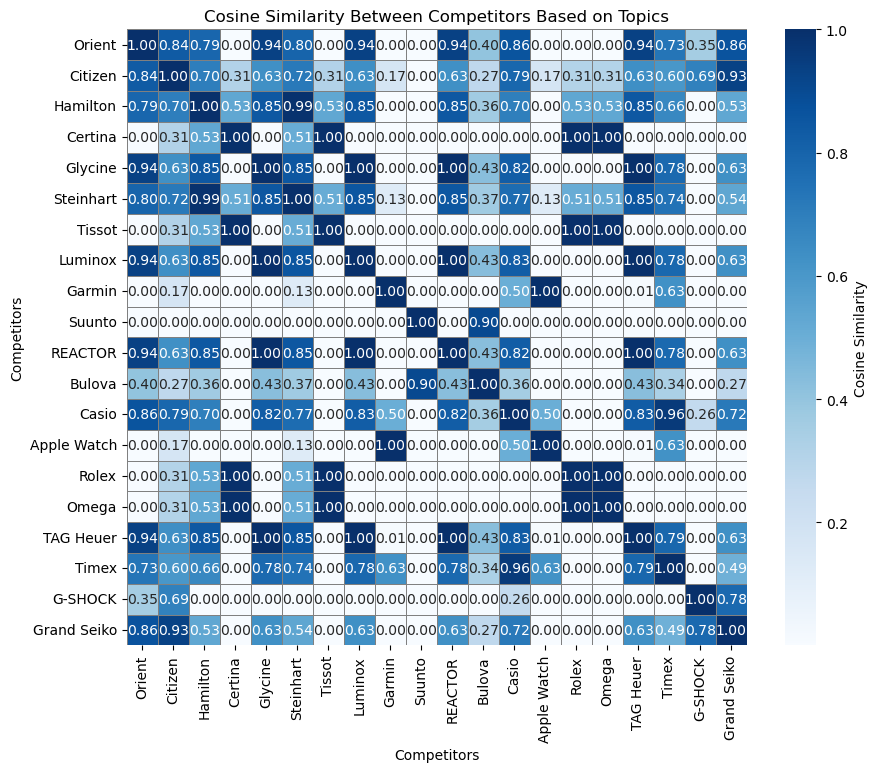

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the cosine similarity matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim_df, annot=True, cmap='Blues', fmt='.2f', 
            xticklabels=cos_sim_df.columns, yticklabels=cos_sim_df.index, 
            linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Cosine Similarity'})
plt.title("Cosine Similarity Between Competitors Based on Topics")
plt.xlabel("Competitors")
plt.ylabel("Competitors")
plt.show()


<div class="alert alert-block alert-info">
</b>Visualize how each competitor correlates with each topic</div>

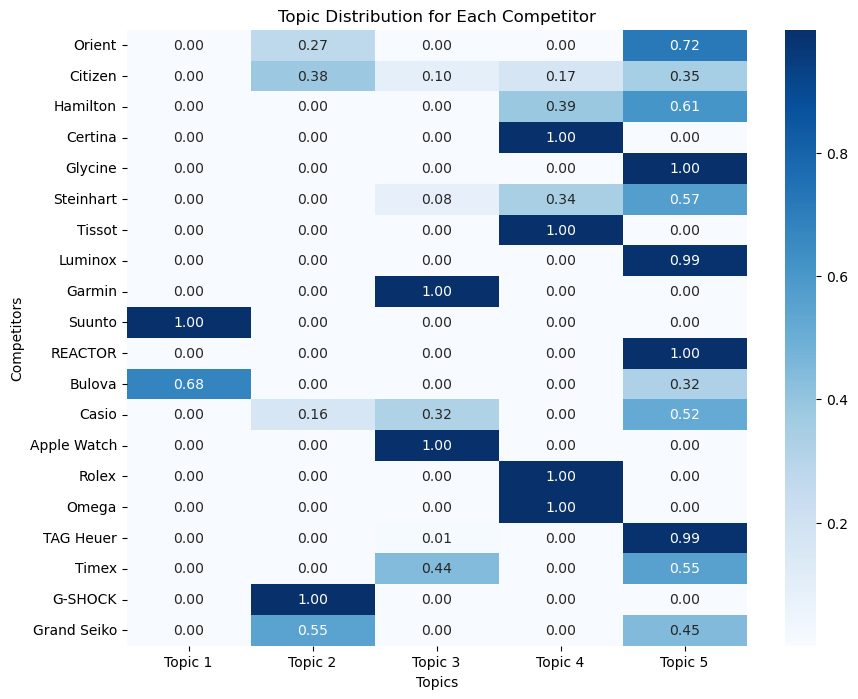

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the topic distribution for each competitor using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(topic_distributions, annot=True, cmap='Blues', xticklabels=[f"Topic {i+1}" for i in range(n_topics)],
            yticklabels=cleaned_texts_no_brand.keys(), fmt='.2f')
plt.title("Topic Distribution for Each Competitor")
plt.xlabel("Topics")
plt.ylabel("Competitors")
plt.show()


<h2>Reputation Indicators Analyses<h2>

In [14]:
# Define keywords for reputation analysis

negative_keywords = [
    "controversy", "lawsuit", "criticism", "scandal", "backlash",
    "decline", "fraud", "bankruptcy", "recall", "failure", "fraud", "lawsuit",
    "pollution", "scandal", "fined", "corruption"
]

positive_keywords = [
    "award", "recognition", "best", "leader", "ranked", "top",
    "innovation", "success", "milestone"
]

positioning_keywords = [
    "leader", "pioneer", "innovator", "luxury", "premium", "affordable",
    "mass-market", "high-end", "sustainable", "ethical", "cutting-edge",
    "exclusive", "revolutionary"
]


In [15]:
def extract_sentences(original_text, keywords):
    """Extract sentences from original text that contain any of the given keywords."""
    sentences = re.split(r'(?<=[.!?])\s+', original_text)  # Split using punctuation
    relevant_sentences = [s for s in sentences if any(word in s.lower() for word in keywords)]
    return relevant_sentences


In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

analyzer = SentimentIntensityAnalyzer()

# Negative sentences extractor
def extract_negative_sentences(text, keywords):
    """Extract sentences with keywords and validate sentiment."""
    sentences = re.split(r'(?<=[.!?])\s+', text)  # Split into sentences
    relevant_sentences = [s for s in sentences if any(word in s.lower() for word in keywords)]
    
    # Keep only sentences that have a negative sentiment
    negative_sentences = [s for s in relevant_sentences if analyzer.polarity_scores(s)['compound'] < -0.2]
    
    return negative_sentences

# Positive sentences extractor
def extract_positive_sentences(text, keywords):
    """Extract sentences with keywords and validate positive sentiment."""
    sentences = re.split(r'(?<=[.!?])\s+', text)  # Split into sentences
    relevant_sentences = [s for s in sentences if any(word in s.lower() for word in keywords)]
    
    # Keep only sentences that have a positive sentiment
    positive_sentences = [s for s in relevant_sentences if analyzer.polarity_scores(s)['compound'] > 0.2]
    
    return positive_sentences


<div class="alert alert-block alert-info">
Get positive, negative, and positioning sentences for each competitor</div>

In [39]:

reputation_analysis = {}

for competitor, text in competitor_dict.items():
    reputation_analysis[competitor] = {
        "negative_mentions": extract_negative_sentences(text, negative_keywords),
        "positive_mentions": extract_positive_sentences(text, positive_keywords),
        "positioning_mentions": extract_sentences(text, positioning_keywords)
    }

import pprint

pprint.pprint(reputation_analysis)



{'Apple Watch': {'negative_mentions': ['Following a ruling by the '
                                       'International Trade Commission on a '
                                       'lawsuit regarding the blood oxygen '
                                       'monitoring feature, Apple temporarily '
                                       'stopped selling Apple Watch Series 9 '
                                       'and Ultra 2 on December 21, 2023, '
                                       'ahead of an import ban going into '
                                       'effect December 26, 2023.',
                                       'Many reviewers described the watch as '
                                       'functional and convenient, while also '
                                       'noting failure to offer as much '
                                       'potential functionality as preceding '
                                       'smartphones.',
                              

<div class="alert alert-block alert-info">
</b>Count number of specific negative issues per brand and display</div>

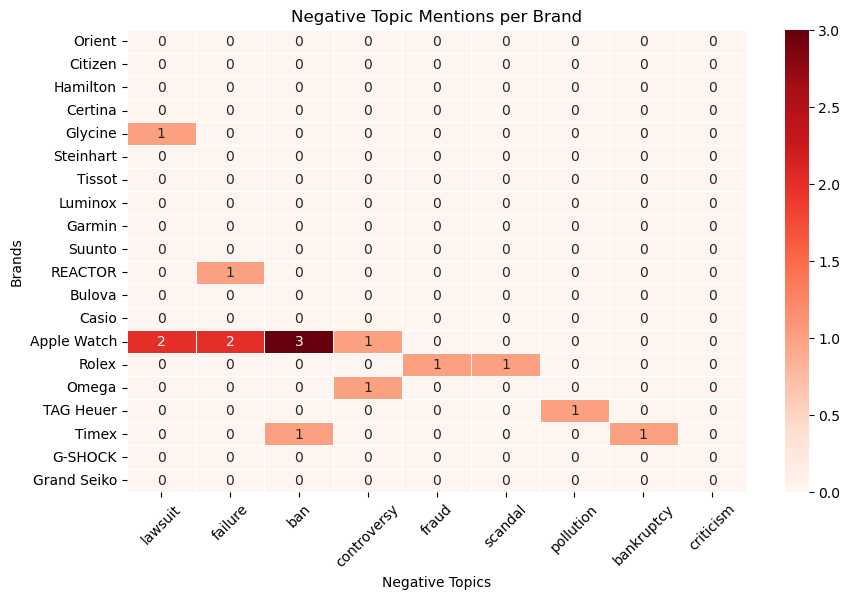

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


keywords = ["lawsuit", "failure", "ban", "controversy", "fraud", "scandal", "pollution", "bankruptcy", "criticism"]

brand_counts = {brand: {kw: 0 for kw in keywords} for brand in reputation_analysis}

for brand, details in reputation_analysis.items():
    for mention in details["negative_mentions"]:
        for kw in keywords:
            if kw in mention.lower():
                brand_counts[brand][kw] += 1

# Convert to DataFrame for heatmap
df = pd.DataFrame(brand_counts).T  # Transpose for better visualization

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap="Reds", linewidths=0.5, fmt="d")
plt.title("Negative Topic Mentions per Brand")
plt.xlabel("Negative Topics")
plt.ylabel("Brands")
plt.xticks(rotation=45)
plt.show()


In [28]:
reputation_analysis.keys()

dict_keys(['Orient', 'Citizen', 'Hamilton', 'Certina', 'Glycine', 'Steinhart', 'Tissot', 'Luminox', 'Garmin', 'Suunto', 'REACTOR', 'Bulova', 'Casio', 'Apple Watch', 'Rolex', 'Omega', 'TAG Heuer', 'Timex', 'G-SHOCK', 'Grand Seiko'])

<div class="alert alert-block alert-info">
</b>Generate wordclouds to display positive, negative sides of each competitor reputation</div>

In [25]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

# Ensure necessary datasets are available
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

industry_specific_words = ['apple', 'orient', 'citizen', 'hamilton', 'certina', 'glycine', 'steinhart', 'tissot', 
                           'luminox', 'garmin', 'suunto', 'reactor', 'bulova', 'casio', 'apple watch', 'rolex', 
                           'omega', 'tag heuer', 'timex', 'g-shock', 'grand seiko', 'watch', 'selling', 'shop', 
                           'wrist', 'timepiece', 'time', 'brand', 'model', 'watchmaker', 'company', 'design', 
                           'camera', 'part','piece', 'watch', 'part', 'system', 'day', 'month', 'minute', 
                           'second','time','designer', 'seiko', 'brand']

def preprocess_text(sentences):
    # Tokenize text
    words = word_tokenize(" ".join(sentences).lower())  
    # Remove punctuation and non-alphabetic words
    words = [word for word in words if word.isalpha()]
    # Remove stopwords and industry-specific words
    words = [word for word in words if word not in stop_words and word not in industry_specific_words]
    # Apply POS tagging
    tagged_words = nltk.pos_tag(words)
    # Keep only nouns and adjectives
    filtered_words = [lemmatizer.lemmatize(word) for word, pos in tagged_words if pos.startswith('NN') or pos.startswith('JJ')]

    return filtered_words

def generate_wordcloud(word_list, title):
    """Generate and display a word cloud."""
    word_freq = Counter(word_list)
    wordcloud = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(8, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ulian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ulian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ulian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ulian\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Skipping word clouds for Citizen (no relevant text).
Skipping word clouds for Certina (no relevant text).

Glycine - Negative Mentions


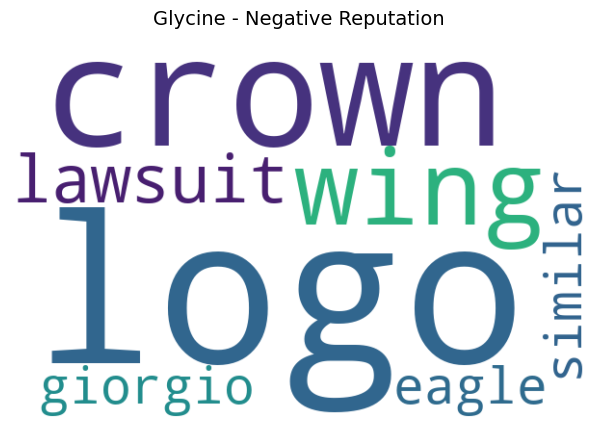

Skipping word clouds for Luminox (no relevant text).

REACTOR - Negative Mentions


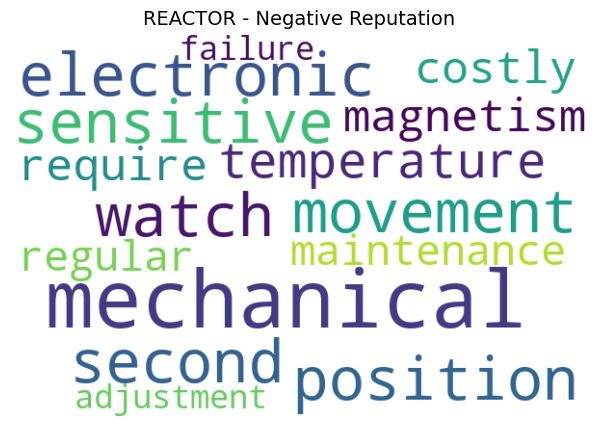


Apple Watch - Negative Mentions


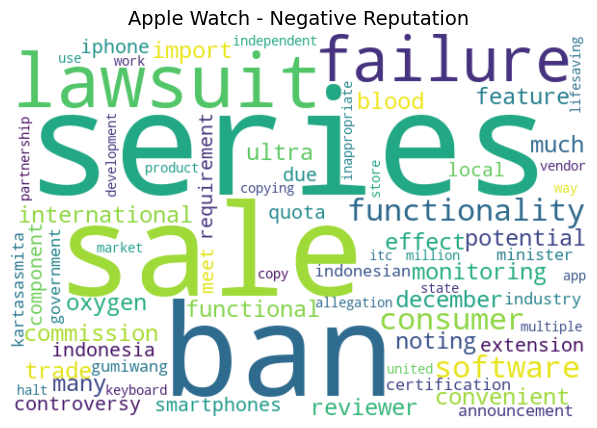


Rolex - Negative Mentions


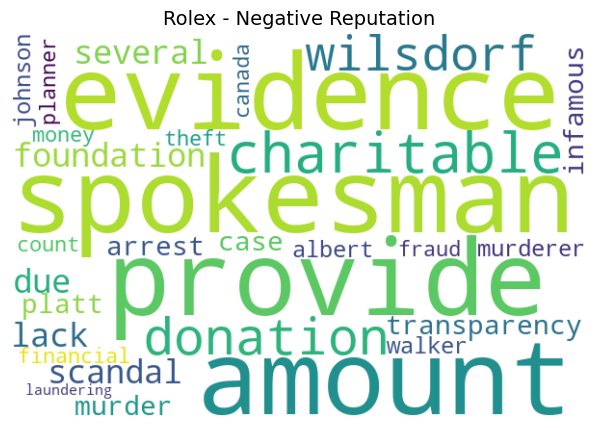


Omega - Negative Mentions


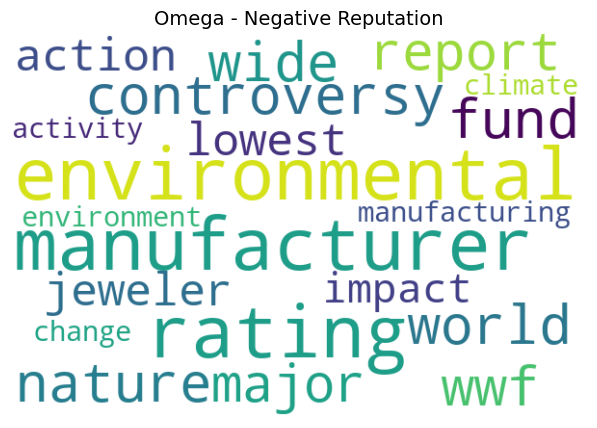


TAG Heuer - Negative Mentions


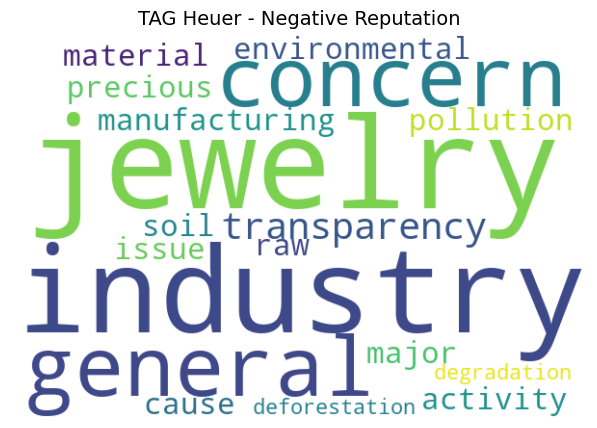


Timex - Negative Mentions


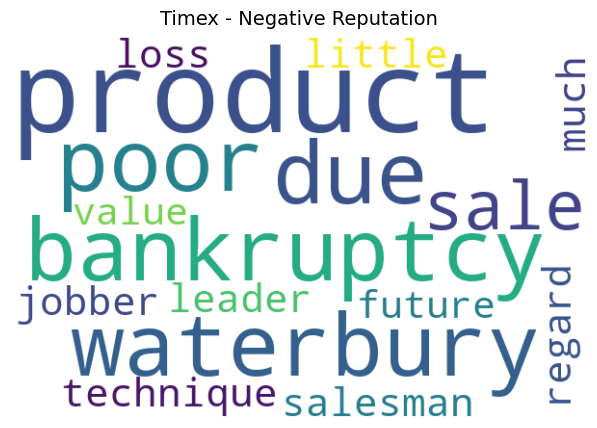

In [30]:
# Generate word clouds for each competitor
for competitor, sentiments in reputation_analysis.items():
    positive_words = preprocess_text(sentiments["positive_mentions"]) if sentiments["positive_mentions"] else []
    negative_words = preprocess_text(sentiments["negative_mentions"]) if sentiments["negative_mentions"] else []
    
    if not positive_words and not negative_words:
        print(f"Skipping word clouds for {competitor} (no relevant text).")
        continue  # Skip this competitor if both are empty
    
    if negative_words:
        print(f"\n{competitor} - Negative Mentions")
        generate_wordcloud(negative_words, f"{competitor} - Negative Reputation")
        
    if positive_words:
        print(f"\n{competitor} - Positive Mentions")
        generate_wordcloud(positive_words, f"{competitor} - Positive Reputation")


<div class="alert alert-block alert-info">
</b>Adjust the generate_wordcloud function in order to display negative clouds side by side </div>

In [32]:
from collections import Counter
from wordcloud import WordCloud
import numpy as np

def generate_wordcloud(word_list):
    """Generate a word cloud and return it as an image array."""
    word_freq = Counter(word_list)
    wordcloud = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    return wordcloud.to_array()  # Convert to NumPy array


<div class="alert alert-block alert-info">
</b>Display negative clouds side by side</div>

Skipping Orient (no negative mentions).
Skipping Citizen (no negative mentions).
Skipping Hamilton (no negative mentions).
Skipping Certina (no negative mentions).
Skipping Steinhart (no negative mentions).
Skipping Tissot (no negative mentions).
Skipping Luminox (no negative mentions).
Skipping Garmin (no negative mentions).
Skipping Suunto (no negative mentions).
Skipping Bulova (no negative mentions).
Skipping Casio (no negative mentions).
Skipping G-SHOCK (no negative mentions).
Skipping Grand Seiko (no negative mentions).


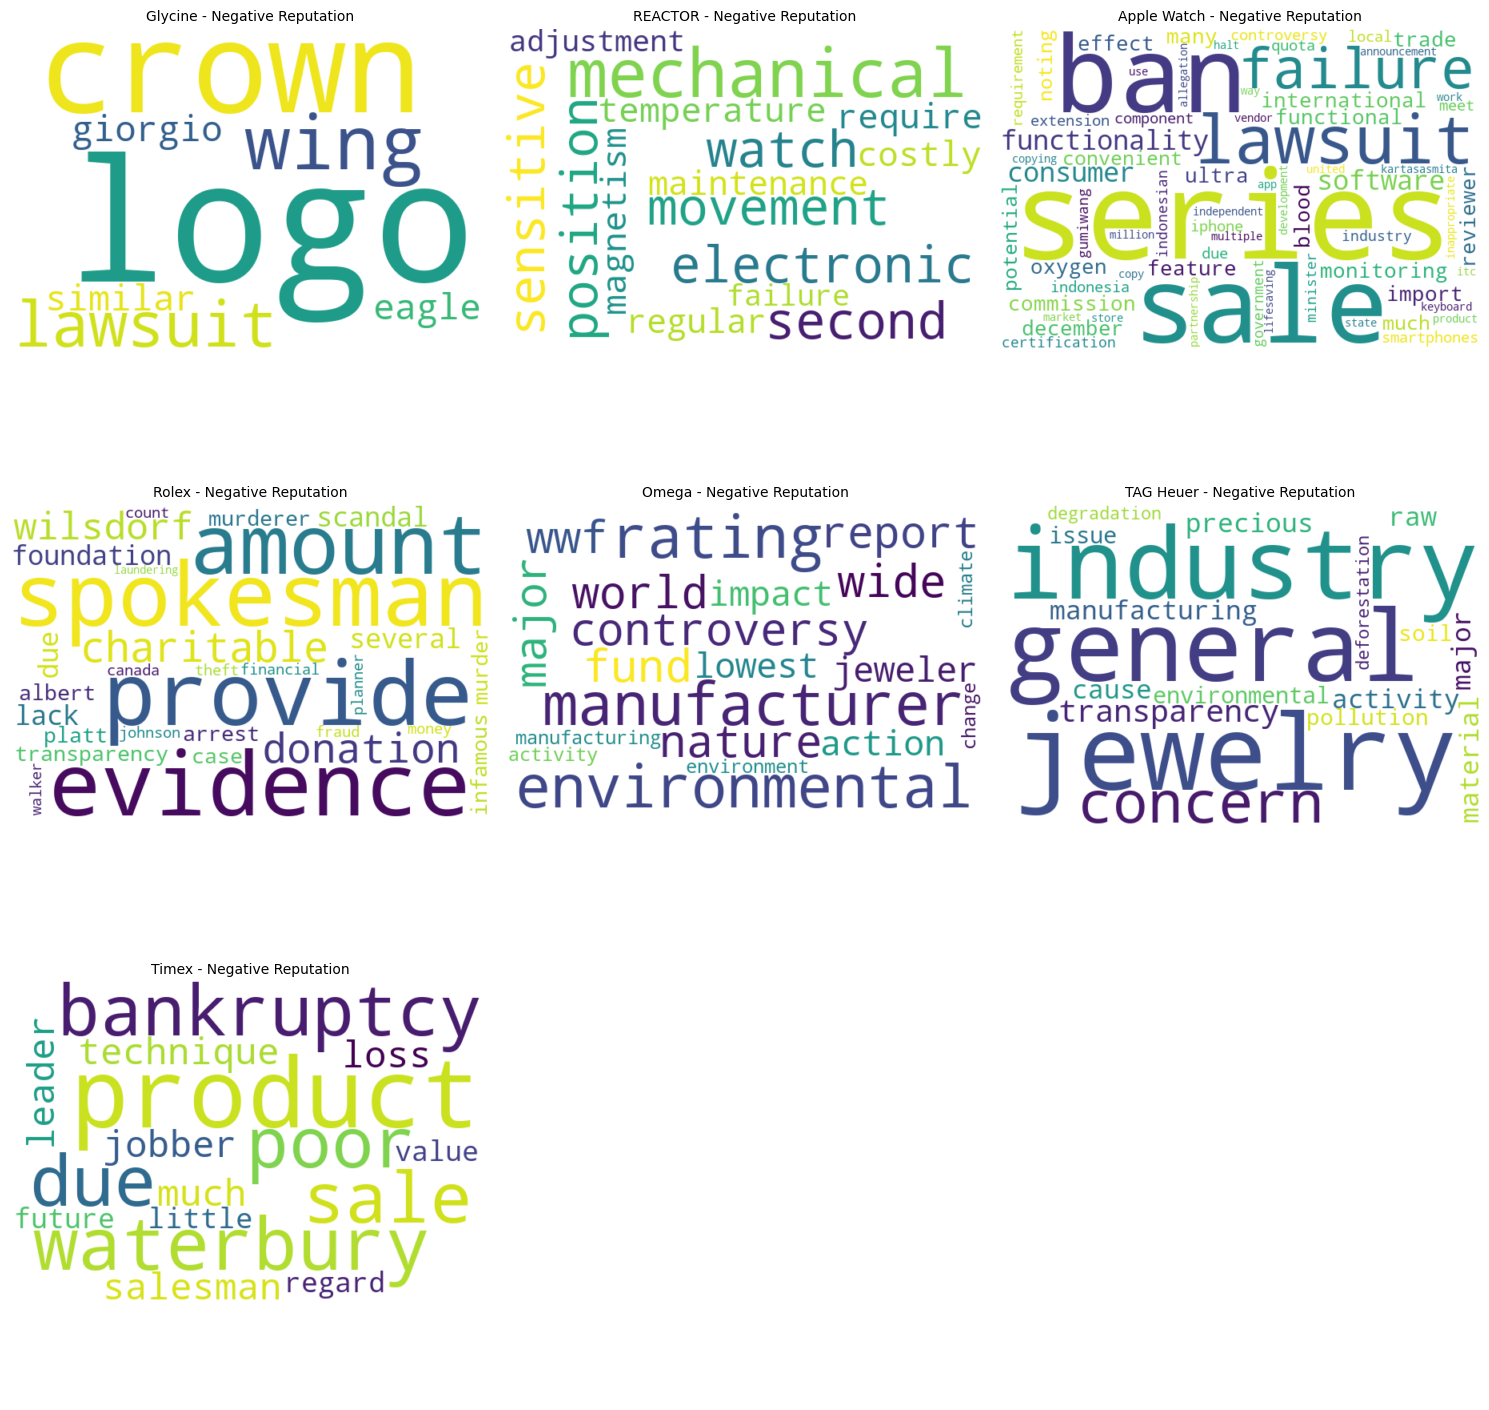

In [33]:
import matplotlib.pyplot as plt
import math

wordclouds = []
titles = []

for competitor, sentiments in reputation_analysis.items():
    negative_words = preprocess_text(sentiments["negative_mentions"]) if sentiments["negative_mentions"] else []
    
    if not negative_words:
        print(f"Skipping {competitor} (no negative mentions).")
        continue  

    wordclouds.append(generate_wordcloud(negative_words))  # Now returns an image array
    titles.append(f"{competitor} - Negative Reputation")

num_clouds = len(wordclouds)
rows = math.ceil(num_clouds / 3)

fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

axes = axes.flatten()

for i, (wc, title) in enumerate(zip(wordclouds, titles)):
    axes[i].imshow(wc, interpolation='bilinear')  # Now wc is a valid image array
    axes[i].set_title(title, fontsize=10)
    axes[i].axis("off")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()
